<a href="https://colab.research.google.com/github/dlwub/Hospital-Drug-Use/blob/master/Hospital_Drug_Use.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install pmdarima

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam

In [ ]:
file_path = '/content/gdrive/MyDrive/Drug_Use_Data_Analysis/Drug_Use_Data_from_Selected_Hospitals.csv'

In [ ]:
df = pd.read_csv(file_path)
df.head()

,FIGURE,SETTING,INDICATOR,GROUP,SUBGROUP,TIME,START_TIME,END_TIME,VALUE,MEASURE
0,0,IP,NaN,NaN,NaN,1,10/01/2022,10/31/2022,35527.0,Count
1,0,IP,NaN,NaN,NaN,2,11/01/2022,11/30/2022,35931.0,Count
2,0,IP,NaN,NaN,NaN,3,12/01/2022,12/31/2022,35722.0,Count
3,0,IP,NaN,NaN,NaN,4,01/01/2023,01/31/2023,33930.0,Count
4,0,IP,NaN,NaN,NaN,5,02/01/2023,02/28/2023,31058.0,Count


In [ ]:
# Convert START_TIME and END_TIME to datetime format
df['START_TIME'] = pd.to_datetime(df["START_TIME"], errors = 'coerce')
df['END_TIME'] = pd.to_datetime(df["END_TIME"], errors = 'coerce')

# Drop rows with missing values
df = df.dropna(subset=['VALUE'])

# Fill missing categorical values with 'Unknown'
categorical_columns = ['SETTING', 'INDICATOR', 'GROUP', 'SUBGROUP', 'MEASURE']
df[categorical_columns] = df[categorical_columns].fillna('Unknown')

# Convert categorical values into Category dtype
for col in categorical_columns:
  df[col] = df[col].astype('category')

df.head()

,FIGURE,SETTING,INDICATOR,GROUP,SUBGROUP,TIME,START_TIME,END_TIME,VALUE,MEASURE
0,0,IP,Unknown,Unknown,Unknown,1,2022-10-01,2022-10-31,35527.0,Count
1,0,IP,Unknown,Unknown,Unknown,2,2022-11-01,2022-11-30,35931.0,Count
2,0,IP,Unknown,Unknown,Unknown,3,2022-12-01,2022-12-31,35722.0,Count
3,0,IP,Unknown,Unknown,Unknown,4,2023-01-01,2023-01-31,33930.0,Count
4,0,IP,Unknown,Unknown,Unknown,5,2023-02-01,2023-02-28,31058.0,Count


### Time-Series Forcasting
Let's start with ARIMA

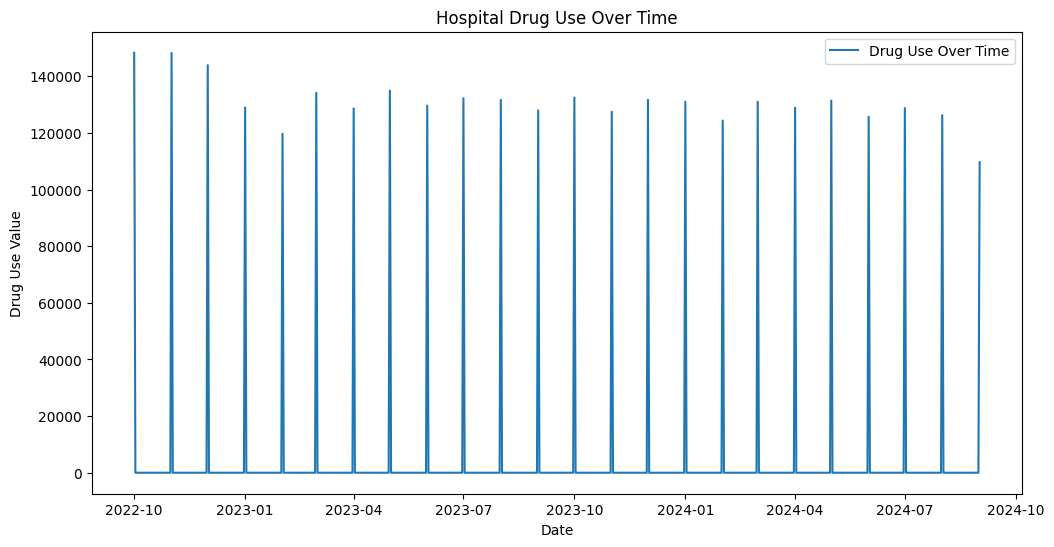

In [ ]:
# Set START_TIME as index
df = df.set_index('START_TIME')

# Aggregate data by day (sum drug use per day)
df = df[['VALUE']].resample('D').sum()

# Plot the time series data
plt.figure(figsize=(12, 6))
plt.plot(df, label='Drug Use Over Time')
plt.xlabel('Date')
plt.ylabel('Drug Use Value')
plt.title('Hospital Drug Use Over Time')
plt.legend()
plt.show()

## Exploratory Data Analysis (EDA)
#### * Rolling Mean and Standard Deviation
#### * Stationarity Check

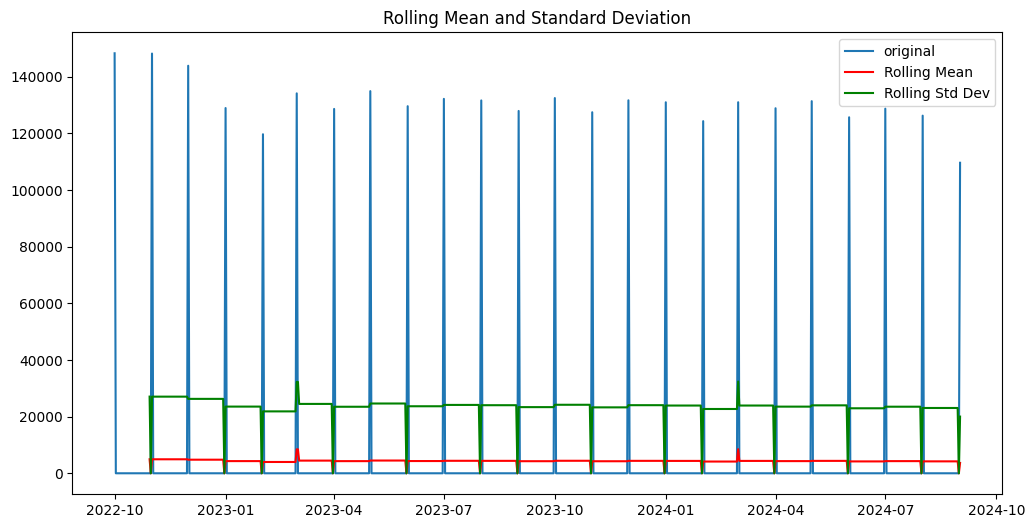

ADF Test Statistic: -10.54138148596726
p-value: 8.632190663918914e-19


In [ ]:
# Rolling mean and standard deviation
df['rolling_mean'] = df['VALUE'].rolling(window=30).mean()
df['rolling_std'] = df['VALUE'].rolling(window=30).std()

plt.figure(figsize=(12, 6))
plt.plot(df['VALUE'], label='original')
plt.plot(df['rolling_mean'], label='Rolling Mean', color='red')
plt.plot(df['rolling_std'], label='Rolling Std Dev', color='green')
plt.legend()
plt.title('Rolling Mean and Standard Deviation')
plt.show()

# ADF Test for Stationarity
adf_test = adfuller(df['VALUE'].dropna())
print("ADF Test Statistic:", adf_test[0])
print("p-value:", adf_test[1])

In [ ]:
# Check if differencing is needed
if adf_test[1] > 0.05:
  df['VALUE_diff'] = df['VALUE'].diff().dropna()
  adf_test_diff = adfuller(df['VALUE_diff'].dropna())
  print("\nAfter Differencing:")
  print("ADF Test Statistic:", adf_test_diff[0])
  print("p-value:", adf_test_diff[1])

In [ ]:
# auto_arima to find best (p, d, q)
auto_model = auto_arima(df['VALUE'].dropna(), seasonal=False, trace=True, stepwise=True)
p, d, q = auto_model.order
print(f"Optimal ARIMA order: {p, d, q}")

model = ARIMA(df['VALUE'], order=(p, d, q))
model_fit = model.fit()

Performing stepwise search to minimize aic


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

 ARIMA(2,0,2)(0,0,0)[0]             : AIC=16175.674, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=16167.001, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=16170.024, Time=0.05 sec


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packag

 ARIMA(0,0,1)(0,0,0)[0]             : AIC=16169.865, Time=0.18 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=16171.865, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=16144.672, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=16146.894, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=16146.625, Time=0.12 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=16148.580, Time=0.29 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.198 seconds
Optimal ARIMA order: (0, 0, 0)


#### (p, d, q) = (0, 0, 0) is just a baseline model equivalent to interpreting the mean of the training data. That means the ARIMA model is not capturing any pattern.

### Forecasting

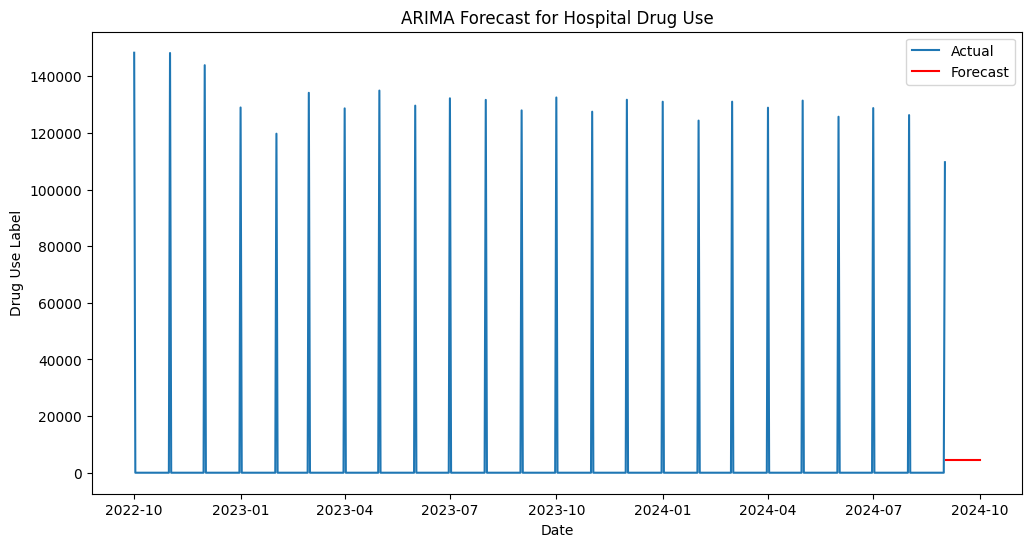

In [ ]:
# Forecast for the next 30 steps
forecast_steps = 30
forecast = model_fit.forecast(steps=forecast_steps)

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(df['VALUE'], label="Actual")
plt.plot(pd.date_range(df.index[-1], periods=forecast_steps + 1, freq='D')[1:], forecast, label="Forecast", color="Red")
plt.xlabel('Date')
plt.ylabel('Drug Use Label')
plt.title('ARIMA Forecast for Hospital Drug Use')
plt.legend()
plt.show()

### Evaluating the ARIMA model

Mean Absolute Error (MAE): 8575.02
Mean Suared Error (MSE): 530972194.83
Root Mean Suared Error (MSE): 23042.83
Mean Absolute Percentage Error (MAPE): inf


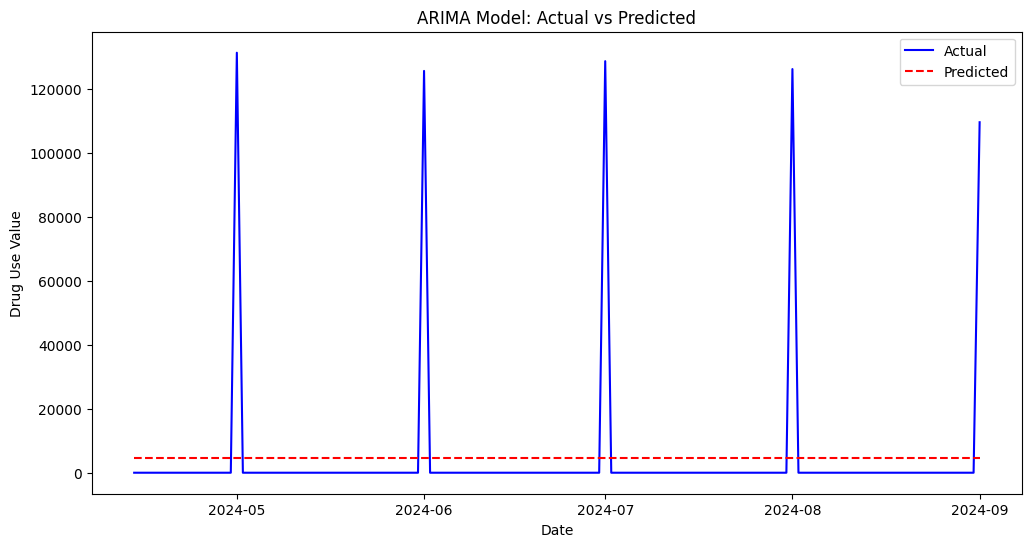

In [ ]:
train_size = int(len(df)*0.8)
train, test = df[:train_size], df[train_size:]

# Fit ARIMA model on training data
model = ARIMA(train['VALUE'], order=(p, d, q))
model_fit = model.fit()

# Forecast for the test period
forecast = model_fit.forecast(steps=len(test))

# Calculate the performance metrics
mae = mean_absolute_error(test['VALUE'], forecast)
mse = mean_squared_error(test['VALUE'], forecast)

rmse = np.sqrt(mse)
mape = np.mean(np.abs((test['VALUE'] - forecast)/test['VALUE']))*100

# Print metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Suared Error (MSE): {mse:.2f}")
print(f"Root Mean Suared Error (MSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}")

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['VALUE'], label='Actual', color='blue')
plt.plot(test.index, forecast, label='Predicted', color='red', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Drug Use Value')
plt.title('ARIMA Model: Actual vs Predicted')
plt.legend()
plt.show()

### Auto-ARIMA has failed to make a sound forecast. Let's try manual-tuning based on ACF/PACF.

<Figure size 1200x500 with 0 Axes>

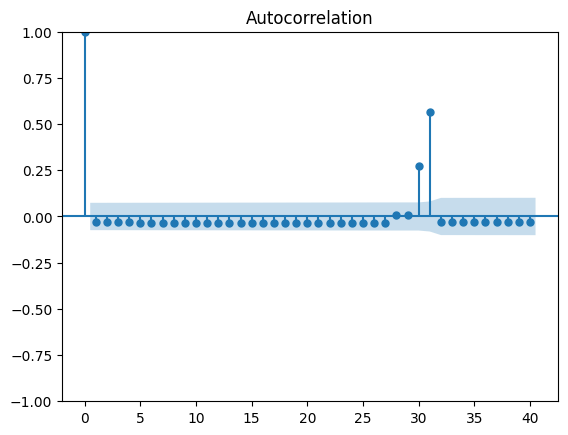

<Figure size 1200x500 with 0 Axes>

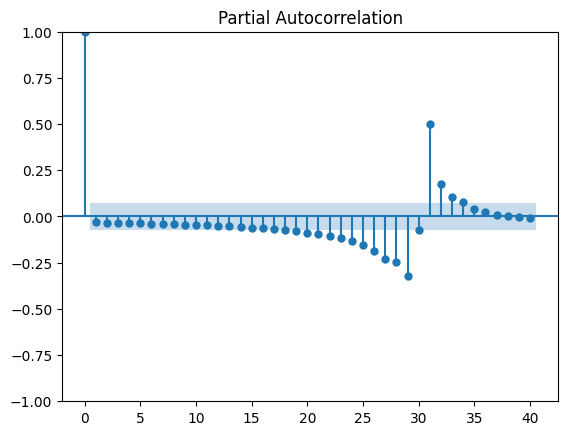

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 5))
plot_acf(df["VALUE"].dropna(), lags=40)
plt.show()

plt.figure(figsize=(12, 5))
plot_pacf(df["VALUE"].dropna(), lags=40)
plt.show()

### The ACF and PACF graphs show a peak at lag 30, which indicates seasonality. Hence, we try seasonal ARIMA (SARIMA).

In [ ]:
auto_sarima = auto_arima(df['VALUE'], seasonal=True, m=30, trace=True, stepwise=True)
p, d, q = auto_sarima.order
P, D, Q, S = auto_sarima.seasonal_order
print(f'Optimal SARIMA Order: ({p}, {d}, {q}) x ({P}, {D}, {Q}, {S})')

sarima_model = sm.tsa.statespace.SARIMAX(df['VALUE'], order=(p, d, q), seasonal_order=(P, D, Q, S))
sarima_fit = sarima_model.fit()
print(sarima_fit.summary())

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[30] intercept   : AIC=inf, Time=6.85 sec
 ARIMA(0,0,0)(0,0,0)[30] intercept   : AIC=16144.672, Time=0.03 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,0)[30] intercept   : AIC=16035.466, Time=0.81 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[30] intercept   : AIC=16055.228, Time=0.71 sec
 ARIMA(0,0,0)(0,0,0)[30]             : AIC=16167.001, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[30] intercept   : AIC=16146.894, Time=0.09 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,0,0)[30] intercept   : AIC=16036.673, Time=13.27 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,1)[30] intercept   : AIC=16037.448, Time=4.92 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,1)[30] intercept   : AIC=16061.169, Time=2.28 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,0,1)[30] intercept   : AIC=16035.615, Time=15.19 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(1,0,0)[30] intercept   : AIC=16093.585, Time=0.54 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,0,0)[30] intercept   : AIC=16016.310, Time=1.27 sec
 ARIMA(2,0,0)(0,0,0)[30] intercept   : AIC=16147.983, Time=0.06 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(2,0,0)[30] intercept   : AIC=16014.468, Time=6.33 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(2,0,1)[30] intercept   : AIC=inf, Time=16.74 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,0,1)[30] intercept   : AIC=16017.135, Time=1.28 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(2,0,0)[30] intercept   : AIC=16004.746, Time=8.73 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(1,0,0)[30] intercept   : AIC=16008.723, Time=1.63 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(2,0,1)[30] intercept   : AIC=16004.799, Time=12.78 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(1,0,1)[30] intercept   : AIC=16008.437, Time=2.09 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(2,0,0)[30] intercept   : AIC=16000.314, Time=9.37 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(1,0,0)[30] intercept   : AIC=16005.672, Time=1.91 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(2,0,1)[30] intercept   : AIC=16000.476, Time=12.34 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(1,0,1)[30] intercept   : AIC=16004.673, Time=2.48 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,0)(2,0,0)[30] intercept   : AIC=15998.469, Time=11.06 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,0)(1,0,0)[30] intercept   : AIC=16004.703, Time=2.66 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,0)(2,0,1)[30] intercept   : AIC=15998.615, Time=16.67 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,0)(1,0,1)[30] intercept   : AIC=16003.319, Time=2.73 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,1)(2,0,0)[30] intercept   : AIC=15997.505, Time=16.10 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,1)(1,0,0)[30] intercept   : AIC=16004.940, Time=5.15 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,1)(2,0,1)[30] intercept   : AIC=15998.847, Time=28.35 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,1)(1,0,1)[30] intercept   : AIC=15996.941, Time=5.26 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,1)(0,0,1)[30] intercept   : AIC=16061.564, Time=3.54 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,1)(1,0,2)[30] intercept   : AIC=15998.749, Time=20.81 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,1)(0,0,0)[30] intercept   : AIC=16152.621, Time=0.28 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,1)(0,0,2)[30] intercept   : AIC=16038.622, Time=11.81 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,1)(2,0,2)[30] intercept   : AIC=inf, Time=46.31 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,1)(1,0,1)[30] intercept   : AIC=16001.610, Time=3.98 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,2)(1,0,1)[30] intercept   : AIC=inf, Time=13.28 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,2)(1,0,1)[30] intercept   : AIC=inf, Time=10.80 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,1)(1,0,1)[30]             : AIC=16000.379, Time=4.85 sec

Best model:  ARIMA(5,0,1)(1,0,1)[30] intercept
Total fit time: 325.486 seconds
Optimal SARIMA Order: (5, 0, 1) x (1, 0, 1, 30)
                                     SARIMAX Results                                      
Dep. Variable:                              VALUE   No. Observations:                  702
Model:             SARIMAX(5, 0, 1)x(1, 0, 1, 30)   Log Likelihood               -7991.189
Date:                            Mon, 17 Feb 2025   AIC                          16000.379
Time:                                    18:33:27   BIC                          16041.364
Sample:                                10-01-2022   HQIC                         16016.220
                                     - 09-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.97

### Optimal SARIMA model is ARIMA(5,0,1)(1,0,1)[30], which indicates AR(5), no differencing, and MA(1), Seasonal AR(1), Seasonal MA(1), and Seasonal Period(30): the seasonal cycle repeates every 30 days. The SARIMA model has significant seasonal components, especially at lag 30, however the model's residuals show high skewness (non-normality) and kurtosis, suggesting some distributional aspects of the data are not fully captured.  Let's try some ML methods: LSTM and XGBoost.

## LSTM

#### Train and fit the model

In [ ]:
data = pd.read_csv("/content/gdrive/MyDrive/Drug_Use_Data_Analysis/Drug_Use_Data_from_Selected_Hospitals.csv")

# Drop unnecessary columns
data_cleaned = data.drop(columns=['FIGURE', 'START_TIME', 'END_TIME'])

# Fill missing categorical values with 'Unknown'
categorical_columns = ['SETTING', 'INDICATOR', 'GROUP', 'SUBGROUP', 'MEASURE']
data_cleaned[categorical_columns] = data_cleaned[categorical_columns].fillna('Unknown')

# Apply one-hot encoding to categorical columns
data_encoded = pd.get_dummies(data_cleaned, columns=categorical_columns, drop_first=True)
data_encoded = data_encoded.astype(np.float32)

# Scale VALUE column
scaler = MinMaxScaler()
data_encoded['VALUE'] = scaler.fit_transform(data_encoded[['VALUE']])

# Convert to numpy arrays
values = data_encoded.values.astype(np.float32)

# Define sequence length for LSTM
seq_length = 30

def create_sequences(data, seq_length):
  X, y = [], []
  for i in range(len(data) - seq_length):
    X.append(data[i:i + seq_length, :-1])
    y.append(data[i + seq_length, -1])
  return np.array(X), np.array(y).reshape(-1)

# Create sequences
X, y = create_sequences(values, seq_length)

# Split into train/test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define LSTM model
model = Sequential([
    LSTM(50, return_sequences = True, input_shape=(seq_length, X.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences = False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Save model
model.save('lstm_drug_usage_model.h5')



Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


201/201 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - loss: 0.1094 - val_loss: 3.7480e-04
Epoch 2/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0081 - val_loss: 0.0017
Epoch 3/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0053 - val_loss: 1.1687e-04
Epoch 4/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0037 - val_loss: 1.1042e-04
Epoch 5/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0032 - val_loss: 4.4812e-05
Epoch 6/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.0023 - val_loss: 1.4110e-05
Epoch 7/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0016 - val_loss: 2.2347e-05
Epoch 8/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0015 - val_loss: 2.1400e-05
Epoch 9/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0010 - val_loss: 6.2781e-05
Epoch 10/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 7.8238e-04 - val_loss: 2.2307e-05
Epoch 11/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 4.9783e-04 - val_loss: 6.9362e-06
Ep

#### Make predictions

In [ ]:
# Predict
predictions = model.predict(X_test)

# Inverse scale the predictions
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


#### Evaluate the model

In [ ]:
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
print(f'MSE: {mse}, RMSE: {rmse}, MAE: {mae}')

MSE: 64750.703125, RMSE: 254.4615945972987, MAE: 233.57827758789062


#### Plot

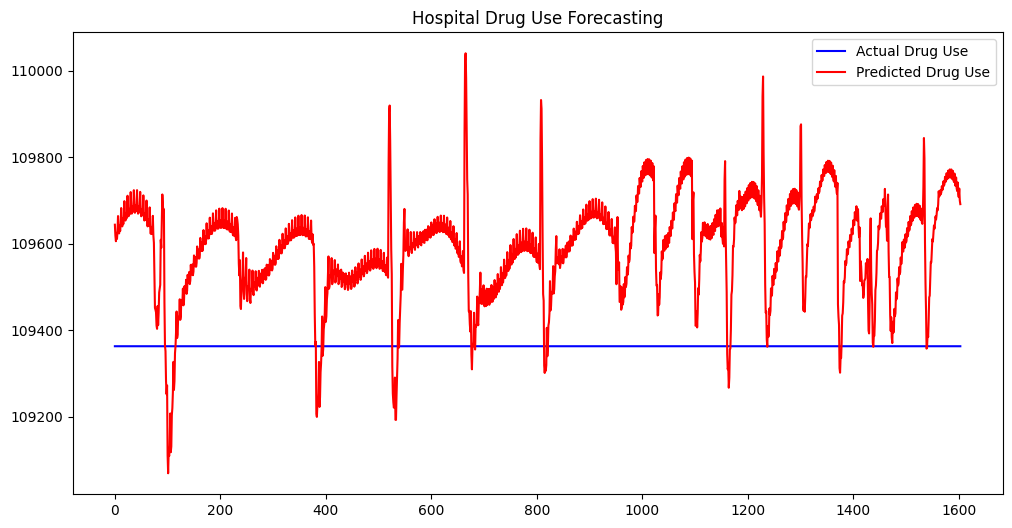

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, color='blue', label="Actual Drug Use")
plt.plot(predictions, color='red', label="Predicted Drug Use")
plt.title('Hospital Drug Use Forecasting')
plt.legend()
plt.show()

## XGBoost

#### We already loaded the data, cleaned it, handled categorical columns, scaled numerical columns, and created sequences. We continue by flattening the created sequences for XGBoost.

#### Flatten created sequence for XGBoost

In [ ]:
# Reshape X from (samples, time-steps, features) to (samples, time-steps*features)
X = X.reshape(X.shape[0], X.shape[1]*X.shape[2])

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)

X_train shape: (6414, 1140) X_test shape: (1604, 1140)


#### Train an XGBoost model

In [ ]:
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.05,
    max_depth = 5
)

# Train the model
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

#### Model Evaluation

In [ ]:
mse = mean_squared_error(predictions, y_test)
rmse = np.sqrt(mse)
mae = mean_absolute_error(predictions, y_test)

print(f"Mean squared error: {mse}, Root Mean Squared Error: {rmse}, Mean absolute error: {mae}")

Mean squared error: 2.7853275241795927e-10, Root Mean Squared Error: 1.6689300537109375e-05, Mean absolute error: 1.6689300537109375e-05


#### Plot

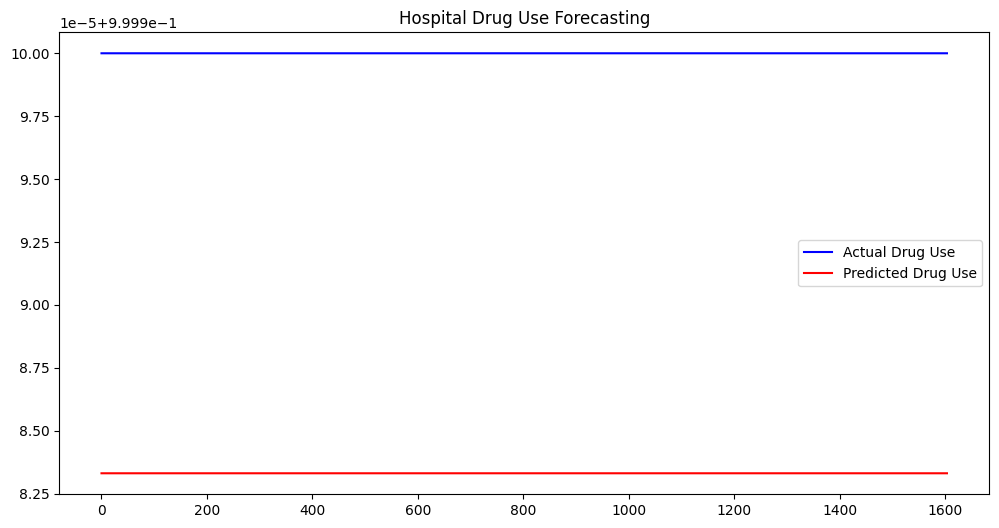

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, color='blue', label="Actual Drug Use")
plt.plot(predictions, color='red', label="Predicted Drug Use")
plt.title('Hospital Drug Use Forecasting')
plt.legend()
plt.show()

## The MSE, RMSE, and MAE scores show that XGBoost is significantly better than LSTM.

## DBSCAN

#### DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is an unsupervised clustering algorithm that groups data points based on density. DBSCAN defines density as the number of points in a given neighborhood. This is controlled by two parameters:
* eps (Epsilon - Radius of Neighborhood): The maximum distance between two points to be considered neighbors.
* min_samples: Minimum number of points required with in eps to be considered a core point.


#### Let's load, preprocess, and normalize the data

In [ ]:
df = pd.read_csv(file_path)

# Select numeric features for clustering
numerical_columns = df.select_dtypes(include=['number']).columns
df_numeric = df[numerical_columns].dropna()

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)

#### Implement DBSCAN

In [ ]:
# Initialize DBSCAN with default parameters
dbscan = DBSCAN(eps=10, min_samples=5)
clusters = dbscan.fit_predict(X_scaled)

# Add cluster labels to the dataset
df_numeric["Cluster"] = clusters

# Display uique cluster labels
df_numeric["Cluster"].value_counts()

,count
Cluster,
0,8048


#### Tune Hyperparameters (eps and min_samples)

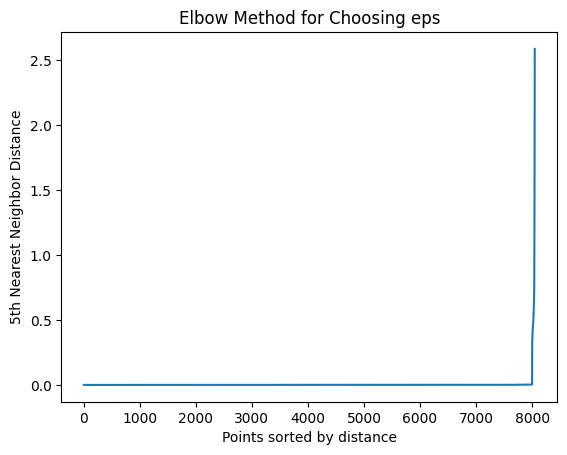

In [ ]:
# Find optimal eps value
neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(X_scaled)
distances, indices = neigh.kneighbors(X_scaled)

# Sort distances for visualization
sorted_distances = np.sort(distances[:, -1])
plt.plot(sorted_distances)
plt.xlabel("Points sorted by distance")
plt.ylabel("5th Nearest Neighbor Distance")
plt.title("Elbow Method for Choosing eps")
plt.show()

In [ ]:
# Most values of sorted_distances are close to 0. The elbow (sharp increase) occurs at index 8000
eps_value = sorted_distances[8000]
dbscan = DBSCAN(eps=eps_value, min_samples=5)
clusters = dbscan.fit_predict(X_scaled)
print(f"Unique clusters: {set(clusters)}")

Unique clusters: {0, 1, 2, 3, 4, 5, 6, -1}


#### Interpreting the result

### The data has 7 (0 to 6) distinct groups (dense regions). Noise points (-1) also exist. Noise points do not belong to any cluster and are points which do not have at least min_sample=5 number of neighbors.

#### Let's check number of Noise points

In [ ]:
num_noise = np.sum(clusters==-1)
total_points = len(clusters)
print(f"Noise points: {num_noise} out of total points: {total_points} ({num_noise/total_points:.2%})")

Noise points: 43 out of total points: 8048 (0.53%)


### The percentage of noise (0.53%) is relatively low, suggesting that most of our data points were successfully assigned to clusters.

#### X_scaled has 3 features. We will use Principal Component Analysis (PCA) to reduce the dimesion to 2 and to plot it.

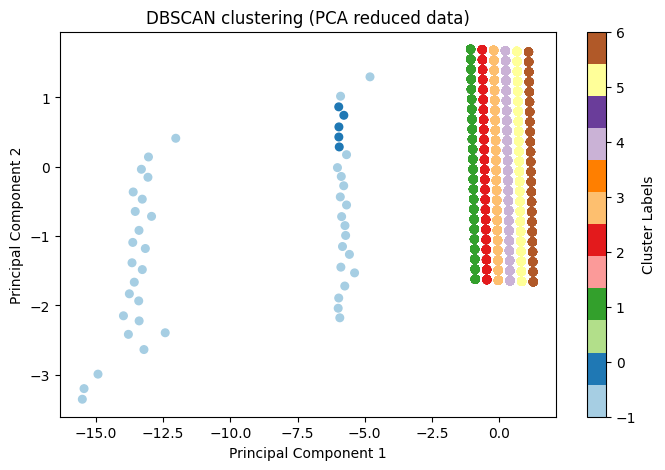

In [ ]:
# Use PCA to reduce the data to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot the clusters
plt.figure(figsize=(8, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='Paired', marker='o', s=30)
plt.title("DBSCAN clustering (PCA reduced data)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label = "Cluster Labels")
plt.show()